In [1]:
import tensorflow
import keras

Using TensorFlow backend.


In [2]:
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import h5py
import os

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
import time
import glob

In [5]:
data_scource = 'origin_data/'
image_rows = 420
image_cols = 580
train_data_path = os.path.join(data_scource, 'train/')

## -----begin test-----

In [26]:
img_9 = cv2.imread(train_data_path + '1_9.tif')
img_14 = cv2.imread(train_data_path + '1_14.tif')
img_1 = cv2.imread(train_data_path + '1_1.tif')

### calculate hitogram
### http://docs.opencv.org/3.1.0/d1/db7/tutorial_py_histogram_begins.html
- though is v3.0 v2.4 will work

In [27]:
hist_9 = cv2.calcHist([img_9],[0],None,[256],[0,256])
hist_14 = cv2.calcHist([img_14],[0],None,[256],[0,256])
hist_1 = cv2.calcHist([img_1],[0],None,[256],[0,256])

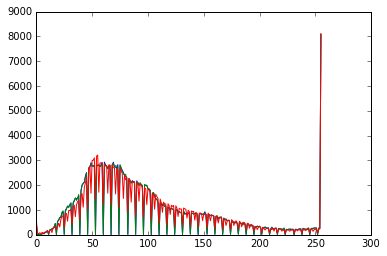

In [29]:
plt.plot(hist_9)
plt.plot(hist_14)
plt.plot(hist_1)

### opencv: histcompare

In [25]:
cv2.compareHist(hist_9, hist_14, cv2.cv.CV_COMP_CORREL)

0.999713792935232

In [30]:
cv2.compareHist(hist_9, hist_1, cv2.cv.CV_COMP_CORREL)

0.9526969345451762

In [32]:
cv2.compareHist(hist_14, hist_1, cv2.cv.CV_COMP_CORREL)

0.9528362204793663

### seems set 0.999 as threshold is a good choice, or it may not, we will see

In [38]:
t0 = time.time()
hist_9 = cv2.calcHist([img_9],[0],None,[256],[0,256])
hist_14 = cv2.calcHist([img_14],[0],None,[256],[0,256])
cv2.compareHist(hist_9, hist_14, cv2.cv.CV_COMP_CORREL)
print (time.time() - t0) * 5600 * 5600/ (47*47)

11.7246076067


## ---finish test---

### reference : https://www.kaggle.com/agalea91/ultrasound-nerve-segmentation/mislabeled-training-images/discussion

In [6]:
train_data_path_conflict = os.path.join(data_scource, 'train_conflict/')

In [7]:
# Load images into dictionary where the keys
# represent patients (first label on training images)

def load_cv2_images(folder):
    imgs, masks, img_ids = {}, {}, {}
    for i in range(47):
        imgs[i+1] = []
        masks[i+1] = []
        img_ids[i+1] = []
    
    paths = glob.glob(folder+'*.tif')
    paths = [p for p in paths if 'mask' not in p]
    
    for p in paths:
        # Read in greyscale image and append to path
        index = int(p.split('/')[2].split('_')[0])
        try:
            imgs[index].append(cv2.imread(p, 0))
            masks[index].append(cv2.imread(p[:-4]+'_mask.tif', 0))
            img_ids[index].append(p.split('/')[2])
        except:
            pass
    
    for i in range(47):
        imgs[i+1] = np.array(imgs[i+1])
        masks[i+1] = np.array(masks[i+1])
    
    return imgs, masks, img_ids
    
imgs, masks, img_ids = load_cv2_images(train_data_path_conflict)

In [8]:
# The function below will find any
# image similar to the input image
def find_pairs(compare_img, compare_mask, compare_id,
               imgs, masks, img_ids,
               compare_index, matches):

    threshold = 0.999
    for i, (img, mask, img_id) in enumerate(zip(imgs, masks, img_ids)):
        
        hist_compare = cv2.calcHist([compare_img],[0],None,[256],[0,256])
        hist_img = cv2.calcHist([img],[0],None,[256],[0,256])
        corr = cv2.compareHist(hist_compare, hist_img, cv2.cv.CV_COMP_CORREL)
        
        if corr > threshold \
        and i != compare_index \
        and (compare_mask.sum() == 0) != (mask.sum() == 0):
            matches.append((compare_img, compare_mask, compare_id, img, mask, img_id))

    return matches

matches = []
for j in range(47):
    for i, (img, mask, img_id) in enumerate(zip(imgs[j+1], masks[j+1], img_ids[j+1])):
        matches = find_pairs(img, mask, img_id,
                             imgs[j+1], masks[j+1], img_ids[j+1],
                             i, matches)
len(matches)

310

In [1]:
# Print the matches, avoiding duplicates

repeats, unique = [], []
for i, m in enumerate(matches):

    # Using pixel sums as an ID for the picture
    if m[0].sum() not in repeats\
    or m[3].sum() not in repeats:
                
        unique.append(m[0].sum())
        fig, ax = plt.subplots(2, 2)
        if m[1].sum() == 0:
            i1, i2 = 1, 0
        else:
            i1, i2 = 0, 1
            
        ax[i1][0].imshow(m[0], cmap='gray')
        ax[i1][0].set_title(m[2])
        ax[i1][1].imshow(m[1], cmap='gray')
        ax[i1][1].set_title(m[2][:-4]+'_mask.tif')
        
        ax[i2][0].imshow(m[3], cmap='gray')
        ax[i2][0].set_title(m[5])
        ax[i2][1].imshow(m[4], cmap='gray')
        ax[i2][1].set_title(m[5][:-4]+'_mask.tif')
        
        fig.subplots_adjust(hspace=0.4)
        plt.show()
        
    repeats.append(m[0].sum())
    repeats.append(m[3].sum())
    if i == 98:
        break

In [13]:
img_conflict = []
for m in matches:
    img_conflict.append(m[5])

In [16]:
np.save('img_remove_id.npy', img_conflict)